In [31]:
import numpy as np
import torch

In [32]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [33]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


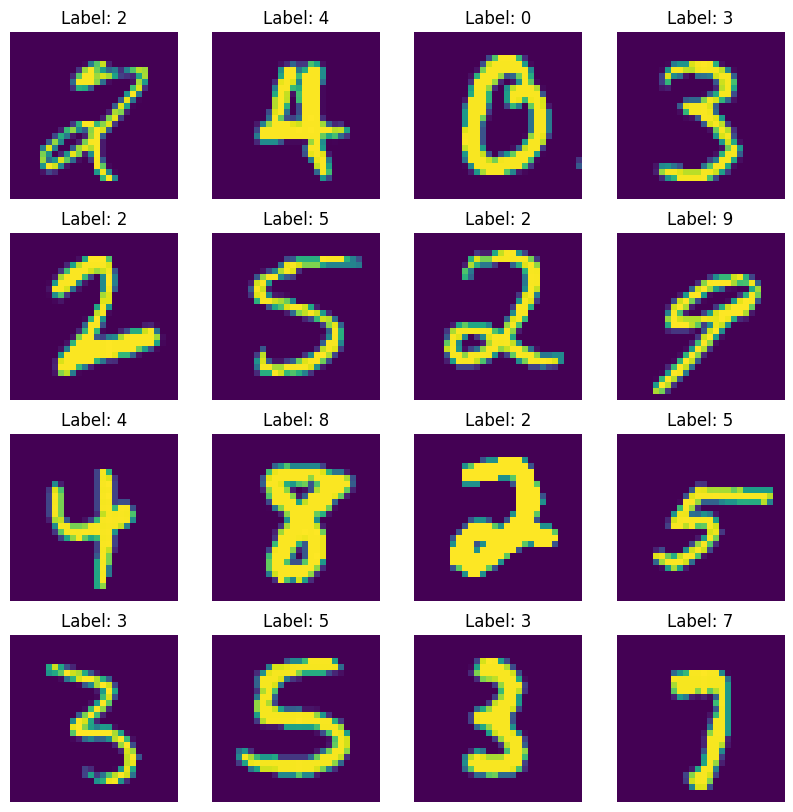

In [34]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [35]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2 = params

    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x


# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2])

In [36]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.2420, -1.4624,  0.5178, -0.8246, -0.8369],
        [ 0.0088, -0.7336,  0.6584, -0.2375,  1.4129],
        [ 0.1968, -1.8291,  1.3406,  0.5262, -0.3944]], requires_grad=True)

In [37]:
def check_accuracy(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [56]:
def train(model_fn, params, learning_rate, r1, c1, print_every=100):
    w1, w2 = params
    
    last_accuracy = 0   
    
    overtime = []
    
    for t, (x, y) in enumerate(loader_train):
            
        scores = model_fn(x, [w1, w2])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            w1.grad.zero_()
            w2.grad.zero_()
            
        overtime.append(w1[r1][c1].item())

        if t % print_every == 0:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
            last_accuracy = check_accuracy(loader_val, model_fn, [w1, w2])
            print()
            
    return last_accuracy

In [57]:
hidden_layer_size = 40
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

In [61]:
hidden_layer_size = 200
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)

train(two_layer_fc, [w1, w2], learning_rate, print_every=200)


Iteration 0, loss = 2.3886
Checking accuracy on the val set
Got 944 / 10000 correct (9.44%)

Iteration 200, loss = 1.0642
Checking accuracy on the val set
Got 8101 / 10000 correct (81.01%)

Iteration 400, loss = 0.6418
Checking accuracy on the val set
Got 8589 / 10000 correct (85.89%)

Iteration 600, loss = 0.6242
Checking accuracy on the val set
Got 8782 / 10000 correct (87.82%)



0.8782